In [11]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline 
import xgboost as xgb
import seaborn as sns 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42) 
sns.set_style('dark')
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score #回归评判标准
from sklearn.metrics import accuracy_score, r2_score, make_scorer, f1_score, recall_score, precision_score,roc_auc_score,confusion_matrix #分类评判依据
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

### 导入数据

In [5]:
orig_data = pd.read_excel("train_minmax_county.xlsx")

In [6]:
X = orig_data.iloc[ :,4:10]
y = orig_data.iloc[:,-1]
X

,DEM,GDP,NDVI,POP,RIVER,ROAD
0,0.022131,0.062483,0.613872,0.160557,0.157143,0.053152
1,0.013677,0.045211,0.532568,0.192191,0.142857,0.071671
2,0.022042,0.098790,0.647406,0.198442,0.142857,0.094137
3,0.145783,0.001140,0.939812,0.007260,0.142857,0.007027
4,0.077805,0.002331,0.835735,0.018344,0.142857,0.014803
...,...,...,...,...,...,...
1978,0.002916,0.000806,0.894777,0.015360,0.161905,0.005886
1979,0.191840,0.000228,0.973863,0.003610,0.154639,0.000837
1980,0.206081,0.000440,0.793080,0.005771,0.142857,0.001127
1981,0.208915,0.000047,0.905375,0.000550,0.165024,0.000792


In [7]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1978    0
1979    0
1980    0
1981    0
1982    0
Name: new_label, Length: 1983, dtype: int64

In [8]:
print(X.shape,y.shape)

(1983, 6) (1983,)


c:\Users\XZD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

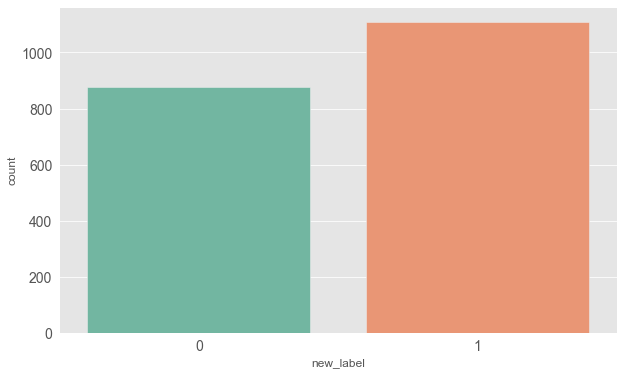

In [9]:
#绘制样本分布情况
plt.figure(figsize=(10, 6))
sns.countplot(y, palette="Set2")
plt.xticks(rotation=0)

### 绘制变量相关性

<AxesSubplot:>

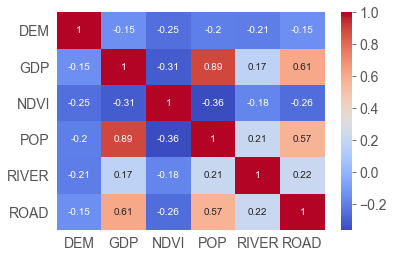

In [10]:
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)

### 划分训练集、测试集,并标准化

In [8]:
# 划分数据集,80% 训练数据和 20% 测试数据
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
print(X_train.shape,y_train.shape)

(1388, 6) (1388,)


### 测试模型基准训练水平

In [13]:

xgb_clf = XGBClassifier(objective='binary:logistic',eval_metric='auc',use_label_encoder=False, seed=2021)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_train)

In [14]:
from sklearn.model_selection import cross_val_score

# Ten-fold cross validation
scores = cross_val_score(xgb_clf, X_train, y_train,
                        scoring = "accuracy", cv=10,
                        n_jobs=-1)
def display_scores(scores):

    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(scores)

Scores: [0.60431655 0.63309353 0.64028777 0.60431655 0.67625899 0.5323741
 0.5971223  0.62589928 0.63043478 0.67391304]
Mean: 0.6218016890835157
Standard deviation: 0.03931867061726279


### 随机搜索方法调整模型参数（可探索其他调参方式）

In [15]:
xgb = XGBClassifier(objective='binary:logistic',
                    eval_metric = 'auc', tree_method='hist', seed=2021,importance_type = 'cover',use_label_encoder=False)
'''
指定学习任务参数:
    objective目标函数。
        二分类   常用binary:logistic 回归任务reg:linear
        多分类   multi:softmax,需要指定类别数量,'num_class':33
        回归任务 reg:linear
    eval_metric 评价函数。
        二分类   常用auc和logloss
        多分类   mlogloss
        回归任务 均方误差mse,均方根误差rmse, 平均绝对值误差mae

'''

"\n指定学习任务参数:\n    objective目标函数。\n        二分类   常用binary:logistic 回归任务reg:linear\n        多分类   multi:softmax,需要指定类别数量,'num_class':33\n        回归任务 reg:linear\n    eval_metric 评价函数。\n        二分类   常用auc和logloss\n        多分类   mlogloss\n        回归任务 均方误差mse,均方根误差rmse, 平均绝对值误差mae\n\n"

调整树模型参数

In [16]:
learning_rate = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
#学习速率。用于控制树的权重,xgb模型在进行完每一轮迭代之后,会将叶子节点的分数乘上该系数,以便于削弱各棵树的影响,避免过拟合。
boost_params = ["gblinear", "gbtree"]
#选择每次迭代的模型。gbtree和dart用于树模型,而gblinear更适用线性模型,gbtree效果远胜gblinear。一般对eta调优时会结合迭代次数进行考虑。
base_score = [0.05,0.15,0.25,0.50,0.75]
#对于所有样本预测为正样本的全局偏置。如果迭代次数够多,改变这个参数对结果不会有影响。
max_depth = [2,3,4,5,6,7,8,9,10]  
#树的最大深度[default=6]。一般取值范围为[3,10],对结果影响较大,越深模型越复杂,越容易过拟合
alpha = [0.1,0.3,0.5,0.7,0.9, 1] 
#L1正则 [default=0]。增大该值将使模型更保守。一般我们做特征选择的时候会用L1正则项。
colsample_bytree= [0.5,0.6,0.7,0.8,0.9,1]
#用于每次分裂一颗树时随机样本（列）采样的比例,即选择多少列作为训练集[default=1],具体的理解就是选择多少特征.取值范围为:（0,1],一般取值为[0.5,1]
min_child_weight = [1,2,3,4,5,6,7,8,9] 
#分裂的叶子节点中样本权重和的最小值[default=1]。如果新分裂的节点的样本权重和小于min_child_weight则停止分裂。增大min_child_weight可以减少过拟合。取值范围为:[0,]。
n_estimators = [100,200,300,400,500,600,700,800,1000] #树的棵树
'''
gamma:用于限制在叶子节点上进一步分裂所需的最小损失函数下降值。分裂节点时,损失函数减小值只有大于等于gamma节点才分裂。gamma越大,算法越保守。取值范围为[0,]一般0.1、0.2这样子
lambda:L2正则 [default=1].增大lambda将使模型可以缓解模型的过拟合。因为加入了惩罚项L2之后,参数公式是w=(X^T XλI)^(-1) X^T Y。可以看出来加入L2正则项使得矩阵正定,将各个特征的贡献都均匀了。
subsample:用于每次分裂一颗树时随机样本(行)采样的比例。取值范围为:(0,1],但是一般取值[0.5,1],当取值为0.5时,较取值1时更能阻止过拟合的发生。
silent: 是否打印训练过程中的信息,0表示打印,1反之
scale_pos_weight [default=1]
用于调节样本不均衡的情况。一般取值可以为:负样本数/正样本数。
'''
params = {
    "colsample_bytree":colsample_bytree,
    "booster":boost_params,
    "max_depth":max_depth,
    "learning_rate":learning_rate,
    "min_child_weight":min_child_weight,
    "n_estimators":n_estimators,
    "base_score":base_score,
    'alpha':alpha
}

xgb_rs = RandomizedSearchCV(xgb, param_distributions=params, cv=10, scoring='accuracy', n_jobs=-1, n_iter=50, random_state=100)
#n_jobs:运行的线程数,-1所有线程,该值需要根据具体情况调整,线程对最终结果有一点影响,曾今测试,线程越多,结果会变差一丢丢
#random_state:这个随机指定一个常数,防止每次结果不一致
#n_inter迭代计算次数,由于网格搜索是随机的,因此可以增加 n_iter 参数以提高性能
xgb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type='cover',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                   param_distributions={'alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
                                        'base_score': [0.05, 0.15, 0.25, 0.5,
                        

In [17]:
xgb_rs.best_params_ #打印搜索出的最佳参数

{'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7,
 'booster': 'gbtree',
 'base_score': 0.15,
 'alpha': 0.5}

In [18]:
xgb_rs.best_score_ #打印最佳得分

0.6434574079866542

In [19]:
xgb_rs.best_estimator_ #打印最佳模型的各项参数

XGBClassifier(alpha=0.5, base_score=0.15, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, predictor='auto',
              random_state=2021, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, seed=2021, subsample=1, tree_method='hist',
              use_label_encoder=False, ...)

In [20]:
features = list(X.columns)
importances = xgb_rs.best_estimator_.feature_importances_
indices = np.argsort(importances)
df4 = pd.DataFrame({'features':features,'importances':importances})
#df4.to_excel('fig5-trace.xlsx')
df4

,features,importances
0,DEM,0.143482
1,GDP,0.185319
2,NDVI,0.184919
3,POP,0.164377
4,RIVER,0.166286
5,ROAD,0.155616


c:\Users\XZD\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\XZD\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\XZD\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\XZD\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\XZD\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


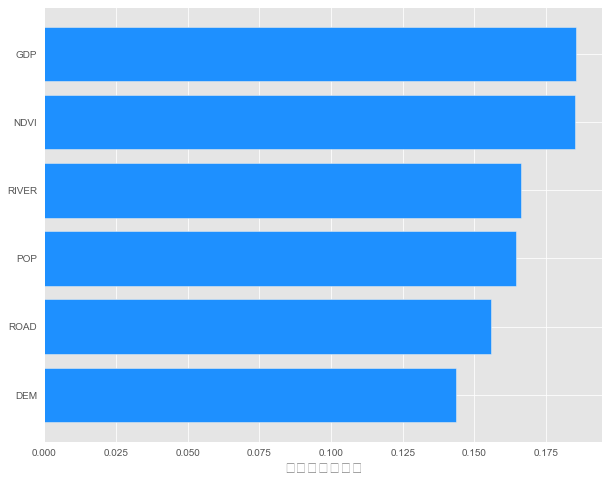

In [21]:
plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices],color='dodgerblue',align='center')#绘制柱形图
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('特征重要性占比',fontsize=15)
#plt.savefig('FeatureImportance.jpg', dpi=900)
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score

# ten-fold cross validation
scores = cross_val_score(xgb_rs.best_estimator_, X_train, y_train,
                        scoring = "accuracy", cv=10,
                        n_jobs=-1)
def display_scores(scores):
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(scores)

Scores: [0.61870504 0.64748201 0.63309353 0.63309353 0.70503597 0.52517986
 0.63309353 0.63309353 0.71014493 0.69565217]
Mean: 0.6434574079866542
Standard deviation: 0.05100150510051608


In [23]:
# predict the test data set
xgb_test = xgb_rs.best_estimator_
xgb_test.fit(X_train,y_train)
y_test_pred = xgb_test.predict(X_test)


In [24]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_test_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test, y_test_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('F1 Score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))

Accuracy: 0.632
ROC AUC: 0.622
Precision: 0.659
Recall: 0.709
F1 Score: 0.683


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       262
           1       0.66      0.71      0.68       333

    accuracy                           0.63       595
   macro avg       0.62      0.62      0.62       595
weighted avg       0.63      0.63      0.63       595



In [26]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print(confmat)

[[140 122]
 [ 97 236]]


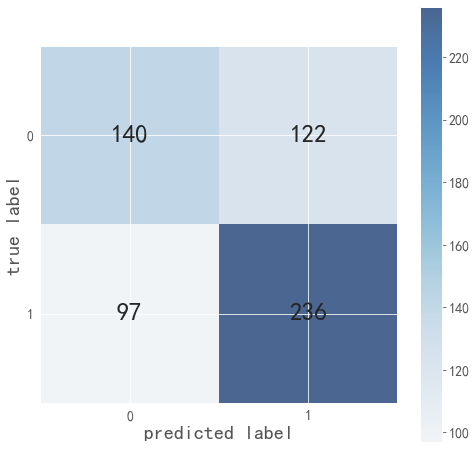

In [27]:
plt.figure(figsize=(8, 8))  #设置图片大小

#设置全局字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

#热力图绘制
plt.imshow(confmat, cmap=plt.cm.Blues,alpha=0.7)#绘制heatmap  
plt.colorbar() #显示colorbar

classes=[0,1]#定义类别
indices = range(len(confmat))#坐标的显示顺序
plt.xticks(indices, classes)#画x轴刻度
plt.yticks(indices, classes)#画y轴刻度

plt.xlabel('predicted label',fontsize=20) #显示x轴标题
plt.ylabel('true label',fontsize=20) #显示y标题


#显示数字文字
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        plt.text(x=j, y=i, s=confmat[i,j], va='center', ha='center',fontsize=25)


#plt.savefig('Major1 Confusion.png', dpi=900)
plt.show()

In [28]:
#predict the non label data
predict_data = pd.read_excel ("predict_minmax_county.xls")
x_predict_data = predict_data.iloc[ :,4:10]
x_predict_data

,DEM,GDP,NDVI,POP,RIVER,ROAD
0,0.251205,0.000017,0.001673,0.000200,0.143109,0.000303
1,0.026929,0.154448,0.823530,0.240048,0.142857,0.254019
2,0.253106,0.000017,0.093458,0.000069,0.145124,0.000235
3,0.314543,0.000190,0.341026,0.002156,0.164835,0.000803
4,0.044838,0.001374,0.901479,0.007570,0.142857,0.003261
...,...,...,...,...,...,...
2850,0.116176,0.000820,0.647959,0.007792,0.163711,0.002281
2851,0.268434,0.000025,0.280549,0.001130,0.155015,0.001075
2852,0.061732,0.000471,0.754607,0.003651,0.142857,0.000957
2853,0.002825,0.039886,0.312296,0.115532,0.142857,1.000000


In [29]:
predict_data

,FID,PAC,NAME,省,DEM,GDP,NDVI,POP,RIVER,ROAD,count
0,2639,620982,敦煌市,甘肃省,0.251205,0.000017,0.001673,0.000200,0.143109,0.000303,72
1,2897,810000,香港特别行政区,香港特别行政区,0.026929,0.154448,0.823530,0.240048,0.142857,0.254019,40
2,417,152921,阿拉善左旗,内蒙古自治区,0.253106,0.000017,0.093458,0.000069,0.145124,0.000235,38
3,2744,640502,沙坡头区,宁夏回族自治区,0.314543,0.000190,0.341026,0.002156,0.164835,0.000803,35
4,860,330523,安吉县,浙江省,0.044838,0.001374,0.901479,0.007570,0.142857,0.003261,26
...,...,...,...,...,...,...,...,...,...,...,...
2850,2850,659008,可克达拉市,新疆维吾尔自治区,0.116176,0.000820,0.647959,0.007792,0.163711,0.002281,0
2851,2851,659009,昆玉市,新疆维吾尔自治区,0.268434,0.000025,0.280549,0.001130,0.155015,0.001075,0
2852,2852,659010,胡杨河市,新疆维吾尔自治区,0.061732,0.000471,0.754607,0.003651,0.142857,0.000957,0
2853,2881,710109,中正区,台湾省,0.002825,0.039886,0.312296,0.115532,0.142857,1.000000,0


In [30]:
predict_results = xgb_rs.best_estimator_.predict_proba(x_predict_data)
predict_results

array([[0.23705852, 0.7629415 ],
       [0.17909598, 0.820904  ],
       [0.34493017, 0.6550698 ],
       ...,
       [0.51004136, 0.48995867],
       [0.3564986 , 0.6435014 ],
       [0.75095165, 0.24904832]], dtype=float32)

In [31]:
df_predict = pd.DataFrame(data=predict_results)
df_predict

,0,1
0,0.237059,0.762941
1,0.179096,0.820904
2,0.344930,0.655070
3,0.496955,0.503045
4,0.112585,0.887415
...,...,...
2850,0.247638,0.752362
2851,0.669234,0.330766
2852,0.510041,0.489959
2853,0.356499,0.643501


In [32]:
results = pd.concat([df_predict,predict_data],axis=1)
#objs 表示需要连接的对象,比如:[df1, df2],需要将合并的数据用综括号包围
#axis=0 表拼接方式是上下堆叠,当axis=1表示左右拼接；
results
#results.to_excel('predict_results1017.xlsx')

,0,1,FID,PAC,NAME,省,DEM,GDP,NDVI,POP,RIVER,ROAD,count
0,0.237059,0.762941,2639,620982,敦煌市,甘肃省,0.251205,0.000017,0.001673,0.000200,0.143109,0.000303,72
1,0.179096,0.820904,2897,810000,香港特别行政区,香港特别行政区,0.026929,0.154448,0.823530,0.240048,0.142857,0.254019,40
2,0.344930,0.655070,417,152921,阿拉善左旗,内蒙古自治区,0.253106,0.000017,0.093458,0.000069,0.145124,0.000235,38
3,0.496955,0.503045,2744,640502,沙坡头区,宁夏回族自治区,0.314543,0.000190,0.341026,0.002156,0.164835,0.000803,35
4,0.112585,0.887415,860,330523,安吉县,浙江省,0.044838,0.001374,0.901479,0.007570,0.142857,0.003261,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,0.247638,0.752362,2850,659008,可克达拉市,新疆维吾尔自治区,0.116176,0.000820,0.647959,0.007792,0.163711,0.002281,0
2851,0.669234,0.330766,2851,659009,昆玉市,新疆维吾尔自治区,0.268434,0.000025,0.280549,0.001130,0.155015,0.001075,0
2852,0.510041,0.489959,2852,659010,胡杨河市,新疆维吾尔自治区,0.061732,0.000471,0.754607,0.003651,0.142857,0.000957,0
2853,0.356499,0.643501,2881,710109,中正区,台湾省,0.002825,0.039886,0.312296,0.115532,0.142857,1.000000,0


### RF建模

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

# Ten-fold cross validation
scores = cross_val_score(rf_clf, X_train, y_train,
                        scoring = "accuracy", cv=10,
                        n_jobs=-1)
def display_scores(scores):

    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(scores)

Scores: [0.61870504 0.58273381 0.5971223  0.61151079 0.64028777 0.60431655
 0.62589928 0.62589928 0.68115942 0.67391304]
Mean: 0.6261547283912001
Standard deviation: 0.02996890524081718


### 随机搜索

网格搜索尝试超参数的所有组合,因此增加了计算的时间复杂度,在数据量较大,或者模型较为复杂等等情况下,可能导致不可行的计算成本,这样网格搜索调参方法就不适用了。  
随机搜索提供更便利的替代方案,该方法只测试你选择的超参数组成的元组,并且超参数值的选择是完全随机的

<img src="https://s2.51cto.com/images/blog/202206/02162251_6298735b5b8bb24847.png?x-oss-process=image/watermark,size_16,text_QDUxQ1RP5Y2a5a6i,color_FFFFFF,t_30,g_se,x_10,y_10,shadow_20,type_ZmFuZ3poZW5naGVpdGk=/format,webp/resize,m_fixed,w_750">

In [34]:
rf = RandomForestClassifier()
params = {'n_estimators' : [50,75,100,125,150,200,250,300,350,400,500,600],
              #n_estimator:参考范围[1,201],弱学习器个数（子模型数）,
              # 太小易欠拟合,太大易过拟合。
              # 增加n_estimators可明显降低整体模型的方差,且不会对子模型的偏差和方差有任何影响；模型的准确度会随着n_estimators的增加而提高
              'max_features' : ['auto','sqrt'],
              #max_features:这个参数用来训练每棵树时需要考虑的最大特征个数,超过限制个数的特征都会被舍弃,默认为auto。
              # 可填入的值有:int值,float（特征总数目的百分比）,“auto”/“sqrt”（总特征个数开平方取整）,“log2”（总特征个数取对数取整）。
              # 默认值为总特征个数开平方取整。值得一提的是,这个参数在决策树中也有但是不重要,因为其默认为None,即有多少特征用多少特征。
              # 为什么要设置这样一个参数呢？原因如下:考虑到训练模型会产生多棵树,如果在训练每棵树的时候都用到所有特征,以来导致运算量加大,二来每棵树训练出来也可能千篇一律,没有太多侧重,
              # 所以设置这个参数,使训练每棵树的时候只随机用到部分特征,在减少整体运算的同时还可以让每棵树更注重自己选到的特征
              'max_depth' : [3,5,10,20,30,40,50,60,70,80,90,100],
              #max_depth:决策树的最大深度；
              'min_samples_split' : [2,3,4,5,6,7,8,9,10],
              #min_samples_split:内部节点再划分所需要的最小样本数,default 2,
              # 如果某节点的样本数少于min_samples_split,则不会继续尝试选择最优特征来进行划分；
              'min_samples_leaf' : [1,2,4,6,8],
              #min_samples_leaf:限制叶子节点的最少样本数,如果某叶子节点数目小于样本数,则会和兄弟节点一起被剪枝。
              'bootstrap' : [True, False]
              #bootstrap:是否有放回的采样,默认True；

            #oob_score: 默认为False,即是否采用袋外样本来评估模型的好坏,
            # 有放回采样中大约36.8%的没有被采样到的数据,我们称之为袋外数据（out of bag,OOB）这些数据没有参与训练集模型的拟合,因此可以用来检测模型的返回能力。
            #criterion:即CART树做划分时对特征的评价标准,分类模型和回归模型的损失函数是不一样的。
            # 分类RF对应的CART分类树默认是gini,另一个是信息增益。回归RF对应的CART回归树默认是均方差MSE,另一个是绝对差MAE
              }
rf_opt = RandomizedSearchCV(estimator = rf, param_distributions = params, scoring = 'accuracy', n_iter = 50, cv = 10, n_jobs = -1, random_state=100)
rf_opt.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         200, 250, 300, 350,
                                                         400, 500, 600]},
                   random_state=100, scoring='accuracy')

In [35]:
rf_opt.best_score_,rf_opt.best_estimator_

(0.6398602856844958,
 RandomForestClassifier(max_depth=30, min_samples_leaf=6, min_samples_split=7,
                        n_estimators=400))

In [36]:
# predict the test data set
from sklearn.metrics import classification_report
rf_test = rf_opt.best_estimator_
rf_test.fit(X_train,y_train)
y_test_pred = rf_test.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_test_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test, y_test_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('F1 Score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Accuracy: 0.640
ROC AUC: 0.628
Precision: 0.662
Recall: 0.730
F1 Score: 0.694
              precision    recall  f1-score   support

           0       0.61      0.53      0.56       262
           1       0.66      0.73      0.69       333

    accuracy                           0.64       595
   macro avg       0.63      0.63      0.63       595
weighted avg       0.64      0.64      0.64       595



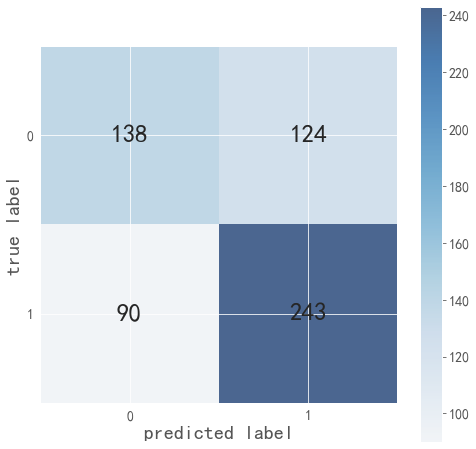

In [37]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
plt.figure(figsize=(8, 8))  #设置图片大小

#设置全局字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

#热力图绘制
plt.imshow(confmat, cmap=plt.cm.Blues,alpha=0.7)#绘制heatmap  
plt.colorbar() #显示colorbar

classes=[0,1]#定义类别
indices = range(len(confmat))#坐标的显示顺序
plt.xticks(indices, classes)#画x轴刻度
plt.yticks(indices, classes)#画y轴刻度

plt.xlabel('predicted label',fontsize=20) #显示x轴标题
plt.ylabel('true label',fontsize=20) #显示y标题


#显示数字文字
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        plt.text(x=j, y=i, s=confmat[i,j], va='center', ha='center',fontsize=25)


#plt.savefig('Major1 Confusion.png', dpi=900)
plt.show()

# 按顺序调参法

In [38]:
RF = RandomForestClassifier(random_state = 66)
score = cross_val_score(RF,X_train,y_train,cv=10).mean()
print('交叉验证得分: %.4f'%score)

交叉验证得分: 0.6261


相对于xgboost等算法,随机森林的调参还是相对比较简单,因为各个参数之间互相影响的程度很小,只需要按步骤调整即可
随机森林中主要用来调参的参数有6个:


## 1）选择criterion参数（决策树划分标准）


和决策树一样,这个参数只有两个参数 'entropy'（熵） 和 'gini'（基尼系数）可选,默认为gini,这里简单测试一下就好

In [39]:
RF = RandomForestClassifier(random_state = 66)
score = cross_val_score(RF,X_train,y_train,cv=10).mean()
print('基尼系数得分: %.4f'%score)
RF = RandomForestClassifier(criterion = 'entropy',random_state = 66)
score = cross_val_score(RF,X_train,y_train,cv=10).mean()
print('熵得分: %.4f'%score)

基尼系数得分: 0.6261
熵得分: 0.6204


这里看出来gini系数更好


## 2）探索n_estimators的最佳值。

接下来正式进入调参环节。
根据上述调参原则,我们先看看用几棵树模型的表现最好  

一般来说,树的棵数越多,模型效果表现越好,但树的棵数达到一定的数量之后,模型精确度不再上升,训练这个模型的计算量却逐渐变大。这个时候,再加树的数量就没必要了。

就好比你饿的时候每吃一个馒头就特别顶饱,但是吃到一定数量的馒头之后,再吃就要撑着了。  
只要找到这个临界值,这个参数就调好了。为了观察得分随着树增多的变化,我们依然绘制决策树调参时的学习曲线。

最优参数以及最高得分: [70.          0.63264519]


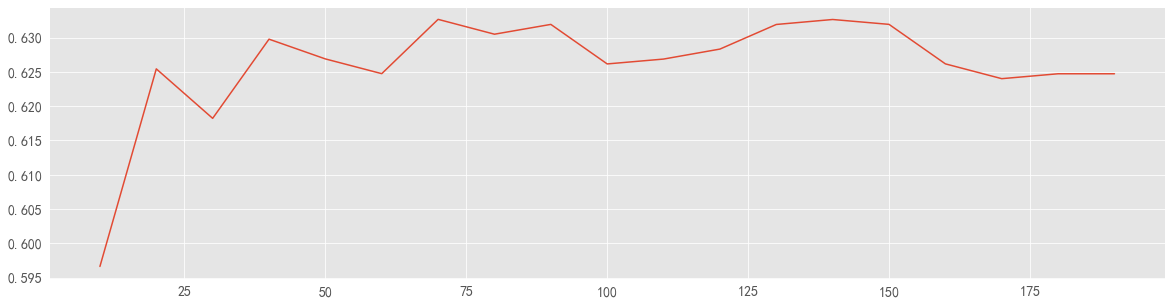

In [40]:
###调n_estimators参数
ScoreAll = []
for i in range(10,200,10):
    DT = RandomForestClassifier(n_estimators = i,random_state = 66) 
    score = cross_val_score(DT,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

根据曲线,我们进一步缩小范围,搜索50-100之间的得分。（这里可以根据经验自己指定）

最优参数以及最高得分: [89.          0.63479825]


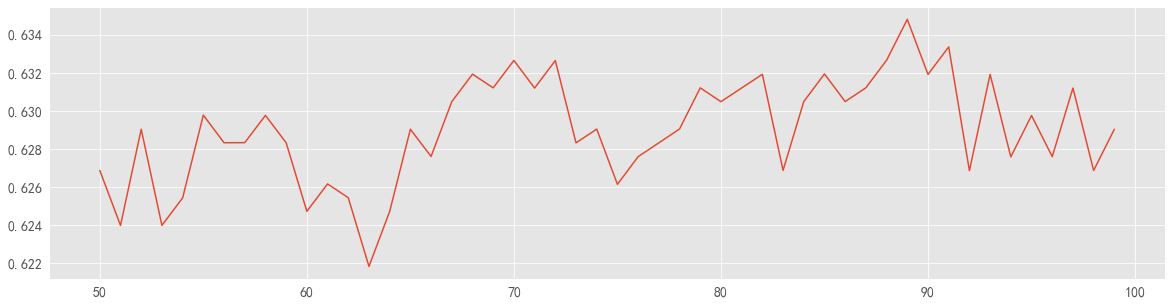

In [41]:
###进一步缩小范围,调n_estimators参数
ScoreAll = []
for i in range(50,100):
    DT = RandomForestClassifier(n_estimators = i,random_state = 66)   #criterion = 'entropy',
    score = cross_val_score(DT,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

可以看到,89为得分最高点,我们暂定n_estimators为89
,接着调下边的参数。

## 3）探索max_depth（树的最大深度）最佳参数

最优参数以及最高得分: [10.          0.64055886]


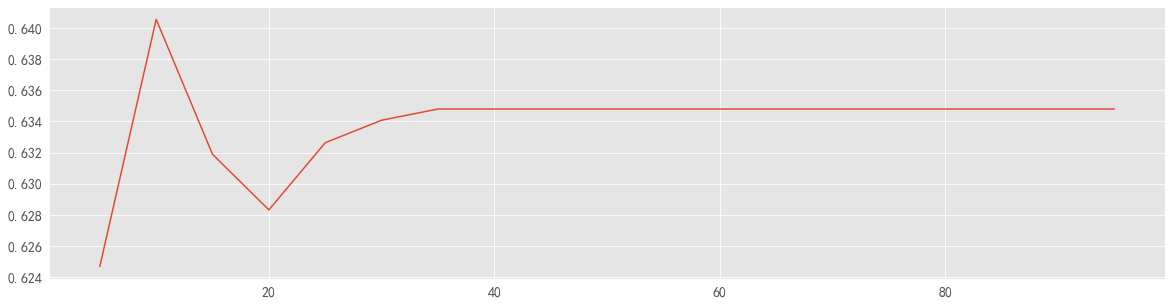

In [42]:
###粗调max_depth参数
ScoreAll = []
for i in range(5,100,5):
    DT = RandomForestClassifier(n_estimators = 89,random_state = 66,max_depth =i ) #,criterion = 'entropy'
    score = cross_val_score(DT,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

由曲线可知,max_depth在10附近取到最优

最优参数以及最高得分: [9.         0.64344177]


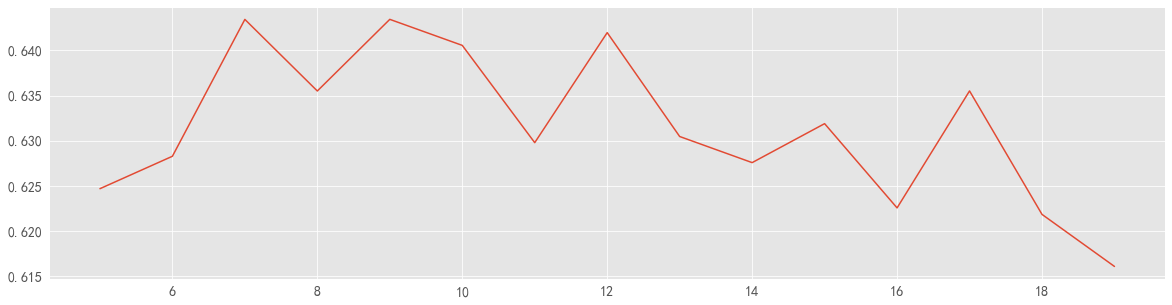

In [43]:
###细调max_depth参数
ScoreAll = []
for i in range(5,20):
    DT = RandomForestClassifier(n_estimators = 89,random_state = 66,max_depth =i ) #,criterion = 'entropy'
    score = cross_val_score(DT,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)
max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

可见最大深度在9处,得分较好,所以暂定max_depth = 9

# 4）探索min_samples_split最佳参数

（分割内部节点所需的最小样本数）   
如果某节点的样本数少于min_samples_split,则不会继续尝试选择最优特征来进行划分；  
min_samples_split最小值就是2,我们就从2开始调起。

最优参数以及最高得分: [18.          0.64991138]


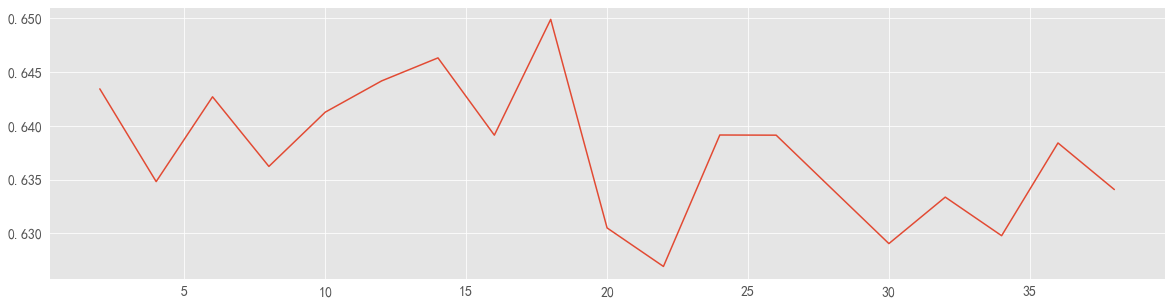

In [44]:
###调min_samples_split参数
ScoreAll = []
for i in range(2,40,2):
    RF = RandomForestClassifier(n_estimators = 89,random_state = 66,max_depth =9,min_samples_split = i ) #,criterion = 'entropy'
    score = cross_val_score(RF,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

由图中可见,min_sample_split在18以后基本上在稳定变小,是一个转折点

最优参数以及最高得分: [18.          0.64991138]


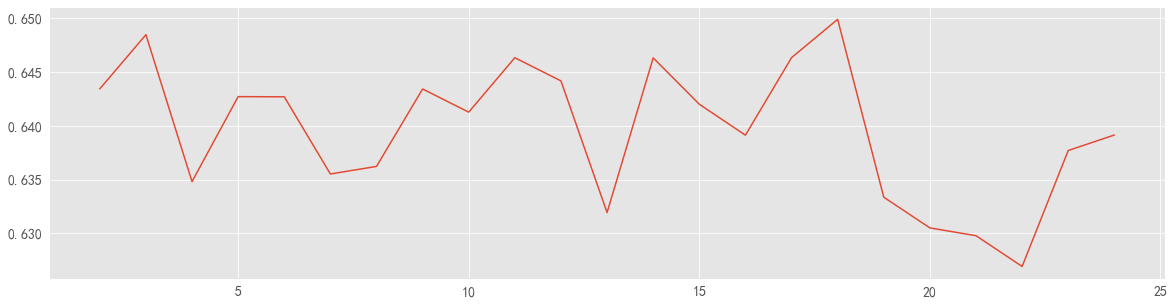

In [45]:
###细调min_samples_split参数
ScoreAll = []
for i in range(2,25):
    RF = RandomForestClassifier(n_estimators = 89,random_state = 66,max_depth =9,min_samples_split = i ) #,criterion = 'entropy'
    score = cross_val_score(RF,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

故暂定min_samples_split为18,复杂度相对较低

## 5）探索min_samples_leaf最佳参数


min_samples_leaf:限制叶子节点的最少样本数,如果某叶子节点数目小于样本数,则会和兄弟节点一起被剪枝。

最优参数以及最高得分: [1.         0.64991138]


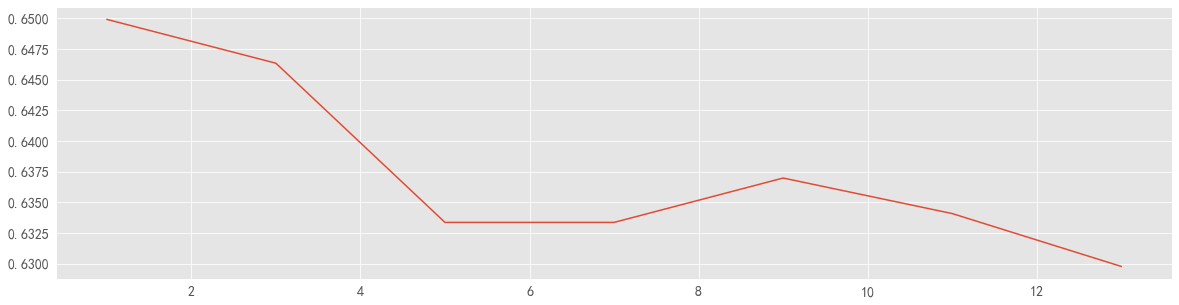

In [46]:
###调min_samples_leaf参数
ScoreAll = []
for i in range(1,15,2):
    DT = RandomForestClassifier(n_estimators = 89,random_state = 66,max_depth =9,min_samples_leaf = i,min_samples_split = 18 ) 
    score = cross_val_score(DT,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的,其实就是找出最高得分对应的索引
print("最优参数以及最高得分:",ScoreAll[max_score])  
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

如果时间充裕,接下来也可以将min_samples_leaf和min_samples_split作为网格参数联调一下,因为这两个参数会相互影响,这里暂时省略这一步。

# 6）在得到的最优参数附近进行小范围网格搜索



因为手动调参时,这些参数可能会相互影响,导致我们得到的参数还不是最优的。所以在最优参数附近进行小范围的网格搜索,排出相互影响的因素,尤其是在数据集量比较少时,小范围搜索一下可能会有意外收获。  
网格搜索————尝试所有可能的组合

<img src='https://s2.51cto.com/images/blog/202206/02162250_6298735adbb272374.png?x-oss-process=image/watermark,size_16,text_QDUxQ1RP5Y2a5a6i,color_FFFFFF,t_30,g_se,x_10,y_10,shadow_20,type_ZmFuZ3poZW5naGVpdGk=/format,webp/resize,m_fixed,w_750'>

In [48]:
import time
start = time.time()

param_grid = {
  'n_estimators':np.arange(80, 90),
  'max_depth':np.arange(5, 15),
  'min_samples_leaf':np.arange(1, 8),
  'min_samples_split':np.arange(2, 20),
# 'max_features':np.arange(0.1, 1)
}

rfc = RandomForestClassifier(random_state=66)
GS = GridSearchCV(rfc,param_grid,cv=10,refit=True,verbose=3,n_jobs=-1)#网格搜索
'''
Parameters:
    cv:交叉验证参数,默认None,使用三折交叉验证。指定fold数量,默认为3,也可以是yield训练/测试数据的生成器。
    n_jobs:并行数,int:个数,-1:跟CPU核数一致, 1:默认值。
    estimator:所使用的分类器,或者pipeline
    param_grid:值为字典或者列表,即需要最优化的参数的取值
    verbose:日志冗长度,int:冗长度,0:不输出训练过程,1:偶尔输出,>1:对每个子模型都输出。
    refit:默认为True,程序将会以交叉验证训练集得到的最佳参数,重新对所有可用的训练集与开发集进行,作为最终用于性能评估的最佳模型参数。即在搜索参数结束后,用最佳参数结果再次fit一遍全部数据集。

Attributes:
    best_estimator_:效果最好的分类器

    best_score_:成员提供优化过程期间观察到的最好的评分

    best_params_:描述了已取得最佳结果的参数的组合

    best_index_:对应于最佳候选参数设置的索引(cv_results_数组的索引)。

Methods:

    decision_function:使用找到的参数最好的分类器调用decision_function。

    fit(X, y=None, groups=None, **fit_params):训练

    get_params(deep=True):获取这个估计器的参数。

    predict(X):用找到的最佳参数调用预估器。(直接预测每个样本属于哪一个类别)

    predict_log_proda(X):用找到的最佳参数调用预估器。（得到每个测试集样本在每一个类别的得分取log情况）

    predict_proba(X):用找到的最佳参数调用预估器。（得到每个测试集样本在每一个类别的得分情况）

    score(X, y=None):返回给定数据上的得分,如果预估器已经选出最优的分类器。

    transform(X):调用最优分类器进行对X的转换。
'''
GS.fit(X_train,y_train)
end = time.time()
print("循环运行时间:%.2f秒"%(end-start))
print(GS.best_params_)
print(GS.best_score_)

Fitting 10 folds for each of 12600 candidates, totalling 126000 fits


### 随机搜索

网格搜索尝试超参数的所有组合,因此增加了计算的时间复杂度,在数据量较大,或者模型较为复杂等等情况下,可能导致不可行的计算成本,这样网格搜索调参方法就不适用了。  
随机搜索提供更便利的替代方案,该方法只测试你选择的超参数组成的元组,并且超参数值的选择是完全随机的

<img src="https://s2.51cto.com/images/blog/202206/02162251_6298735b5b8bb24847.png?x-oss-process=image/watermark,size_16,text_QDUxQ1RP5Y2a5a6i,color_FFFFFF,t_30,g_se,x_10,y_10,shadow_20,type_ZmFuZ3poZW5naGVpdGk=/format,webp/resize,m_fixed,w_750">

In [ ]:
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

# 指定采样的参数和分布
param_dist = {
  'n_estimators':np.arange(80, 90),
  'max_depth':np.arange(5, 15),
  'min_samples_leaf':np.arange(1, 8),
  'min_samples_split':np.arange(2, 20),
  #'max_features':np.arange(0.1, 1)
}
rfc = RandomForestClassifier(random_state=66)
random_search = RandomizedSearchCV( 
    rfc,  #clf1:设置训练的学习器
    scoring='accuracy', #精度评价方式
    param_distributions=param_dist, #字典类型,放入参数搜索范围
    n_iter=200, #训练50次,数值越大,获得的参数精度越大,但是搜索时间越长
    refit=True,  #默认为True,程序将会以交叉验证训练集得到的最佳参数,重新对所有可用的训练集与开发集进行,作为最终用于性能评估的最佳模型参数。即在搜索参数结束后,用最佳参数结果再次fit一遍全部数据集。
    verbose=3, #日志冗长度,int:冗长度,0:不输出训练过程,1:偶尔输出,>1:对每个子模型都输出。
    n_jobs = -1 #使用所有的CPU进行训练,默认为1,使用1个CPU
    ) 
random_search.fit(X_train, y_train)
random_search.best_params_,random_search.best_estimator_,random_search.best_score_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


0.6491520141287692

### 贝叶斯搜索

贝叶斯搜索使用贝叶斯优化技术对搜索空间进行建模,以尽快获得优化的参数值。  
它使用搜索空间的结构来优化搜索时间。  
贝叶斯搜索方法使用过去的评估结果来采样最有可能提供更好结果的新候选参数（如下图所示）。

Ramdom search时间开销小，但平均效果可能不佳。
Grid search时间开销大，平均效果好。
Bayesian optimizaiton 则是综合了两者的优点，综合效果可能会更好。

<img src='https://s2.51cto.com/images/blog/202206/02162251_6298735be95ef9344.png?x-oss-process=image/watermark,size_16,text_QDUxQ1RP5Y2a5a6i,color_FFFFFF,t_30,g_se,x_10,y_10,shadow_20,type_ZmFuZ3poZW5naGVpdGk=/format,webp/resize,m_fixed,w_750'>


我们输入一组超参数，然后得到一个output（一般是performance），但是我们不知道这个超参数和output的函数关系。

1、surrogate（代理/代替）函数：用于拟合超参数和performance关系的函数

2、acquisition函数：用于确定下一次迭代要尝试什么超参数  

Step1：首先随机尝试一些点（超参数），得到他们的output   
Step2：使用surrogate函数去拟合Step1的结果   
Step3：根据acquisition函数确定下一次迭代要尝试的点 Step4：不断尝试，直到满足停止条件


这是一个基于CV实现的贝叶斯超参数寻优，是一个封装好的函数，调用非常方便。

In [ ]:
from skopt import BayesSearchCV
# 参数范围由下面的一个指定
from skopt.space import Real, Categorical, Integer
search_spaces = {
 'n_estimators':np.arange(80, 90),
  'max_depth':np.arange(5, 15),
  'min_samples_leaf':np.arange(1, 8),
  'min_samples_split':np.arange(2, 20),
# 'max_features':np.arange(0.1, 1)
}

bayes_search = BayesSearchCV( 
    estimator=RandomForestClassifier(random_state=66),  #sklearn中的学习器，且要带有score或者scoring参数
    search_spaces=search_spaces, #estimator所支持的超参数
    scoring='accuracy', #一个评分函数，可以自定义，传入的可以是字符串、函数。如果没传入，则默认是estimator中的score方法
    n_iter=100, #选择要尝试的超参数组合数目，越多越精准，耗费越大
    cv=10, 
    # verbose=3,
    n_jobs=-1 #利用的内核数
) 
bayes_search.fit(X_train, y_train)
bayes_search.best_params_,bayes_search.best_estimator_,bayes_search.best_score_

(OrderedDict([('max_depth', 9),
              ('min_samples_leaf', 1),
              ('min_samples_split', 18),
              ('n_estimators', 81)]),
 RandomForestClassifier(max_depth=9, min_samples_split=18, n_estimators=81,
                        random_state=66),
 0.6513450109477635)

利用shapely进行预测

In [22]:
import shap
import json 
model = XGBClassifier(alpha=0.5, base_score=0.15, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=7,  monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, predictor='auto',
              random_state=2021, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, seed=2021, subsample=1, tree_method='hist',
              use_label_encoder=False).fit(X,y)
# 使用SHAP解释模型预测
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [23]:
shap_values[0]

.values =
array([ 0.00581268,  1.1870532 ,  0.11288057, -0.98749477,  0.40300262,
        1.5383449 ], dtype=float32)

.base_values =
0.316808

.data =
array([0.02213124, 0.06248295, 0.61387153, 0.16055708, 0.15714286,
       0.05315154])

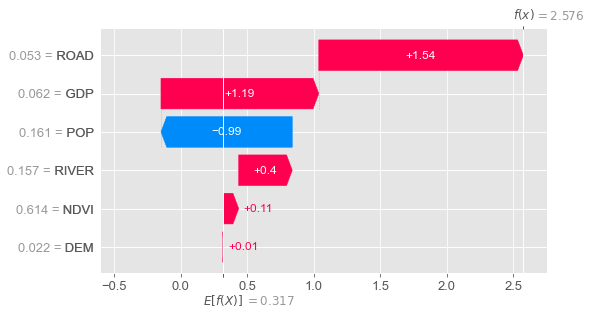

In [24]:
# 第0个样本的解释：以瀑布图形式可视化
shap.plots.waterfall(shap_values[0])

In [28]:
# 第0个样本的解释：以力图形式可视化
shap.plots.force(shap_values[0])

In [29]:
# 所有样本的解释：以力图形式可视化
shap.force_plot(explainer.expected_value, shap_values.values, X)

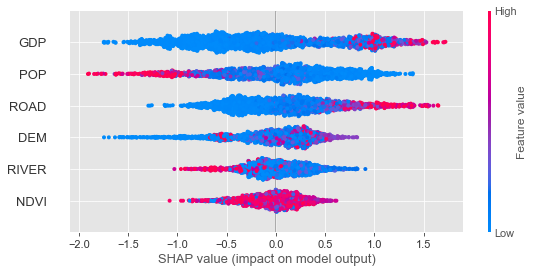

In [30]:
# 全局解释
shap.summary_plot(shap_values, X)

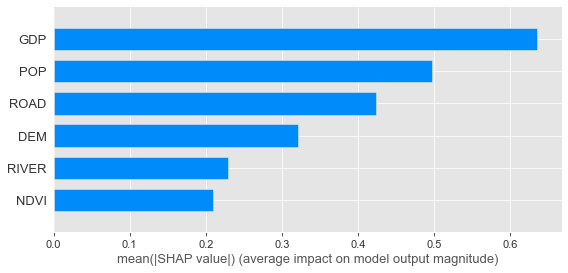

In [31]:
# 取每个特征的SHAP值的绝对值的平均值作为该特征的重要性
shap.summary_plot(shap_values, X, plot_type="bar")

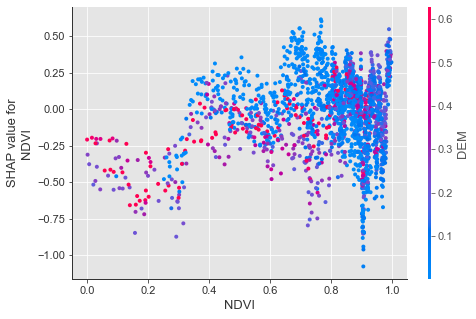

In [33]:
# 特征依赖
shap.dependence_plot("NDVI", shap_values.values, X, interaction_index='DEM')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


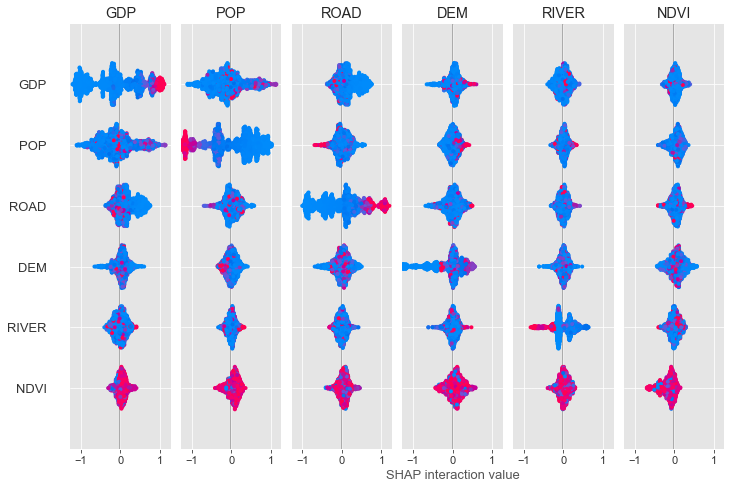

In [34]:
# 特征交互解释
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)


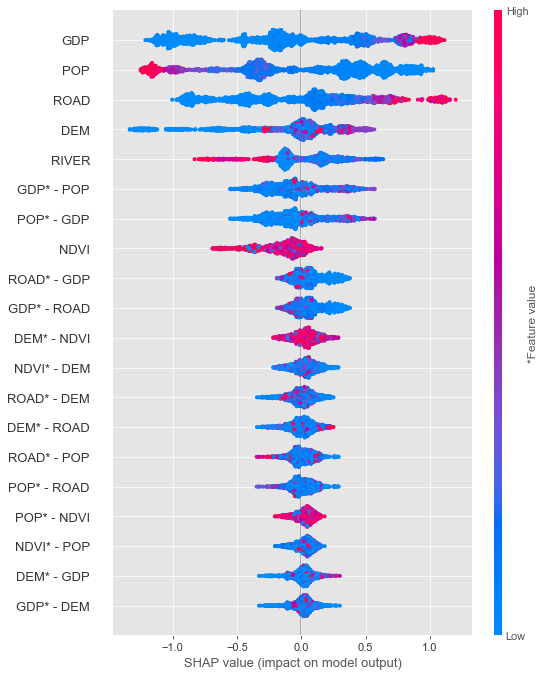

In [35]:
shap.summary_plot(shap_interaction_values, X,max_display=20,plot_type="compact_dot")